# Predict bed counts without using patient snapshots

There are situations where we want to predict bed count distributions without having details of the patients, for example:

* when predicting the number of beds needed for patients yet-to-arrive to the Emergency Department, who will need a bed within a prediction window
* when predicting the number of beds needed for emergency patients who arrive via other routes, or for elective patients

In these situations, the Electronic Health Record (EHR) may not have any record until the moment the patient arrives at the hospital. For electives, the patient may be on a 'To Come In' list, but in the simplest case, we might want to predict based on past patterns of such arrivals between a prediction time (eg 09:30) and the end of a prediction window (eg 8 hours later).  

For these situations, we can learn patterns from past data, and use these to predict a bed count distribution at the aggregate level.

In this notebook, I show how `patientflow` can be used to prepare group snapshots in this way. I'll use the example of predicting the number of beds needed for patients yet-to-arrive to the Emergency Department

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

## Set up prediction times

The first step is to specify the times of day at which we want to create predictions. 

In [3]:
prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] # each time is expressed as a tuple of (hour, minute)

## Create fake arrival times

First I generate some fake data on patients in an Emergency Department (ED)

In [10]:
from patientflow.generate import create_fake_finished_visits
visits_df, _, _ = create_fake_finished_visits('2023-01-01', '2023-04-01', 25)
visits_df.head()

,patient_id,visit_number,arrival_datetime,departure_datetime,is_admitted,age
0,1658,14,2023-01-01 03:31:47,2023-01-01 08:00:47,0,30
1,238,20,2023-01-01 04:25:57,2023-01-01 07:43:57,1,61
2,354,1,2023-01-01 05:21:43,2023-01-01 08:52:43,1,86
3,114,3,2023-01-01 08:01:26,2023-01-01 09:38:26,0,33
4,497,10,2023-01-01 08:20:52,2023-01-01 11:20:52,0,59


For this analysis I only want to know about admitted patients, so I will delete the non-admitted. I will set the arrival_datetime as the index column

In [37]:
import pandas as pd

inpatient_arrivals = visits_df[visits_df.is_admitted == 1].rename(columns = {'departure_datetime': 'admitted_to_ward_datetime'}).drop(columns = 'is_admitted')

inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'])

inpatient_arrivals.dtypes

In [38]:
from datetime import datetime, time, timedelta, date

# Create date range
snapshot_dates = []
start_date = date(2023, 1, 1)
end_date = date(2023, 4, 1)

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

print('First ten snapshot dates')
snapshot_dates[0:10]

First ten snapshot dates


[datetime.date(2023, 1, 1),
 datetime.date(2023, 1, 2),
 datetime.date(2023, 1, 3),
 datetime.date(2023, 1, 4),
 datetime.date(2023, 1, 5),
 datetime.date(2023, 1, 6),
 datetime.date(2023, 1, 7),
 datetime.date(2023, 1, 8),
 datetime.date(2023, 1, 9),
 datetime.date(2023, 1, 10)]

## Train a simple Poisson model to predict the patients who are yet-to-arrive

In [48]:

def count_yet_to_arrive(df, snapshot_dates, prediction_times, prediction_window_hours):
    """
    Count patients who arrived after a prediction time and were admitted to a ward 
    within a specified window.
    """
    # Create an empty list to store results
    results = []
    
    # For each combination of date and time
    for date_val in snapshot_dates:
        for hour, minute in prediction_times:
            # Create the prediction datetime
            prediction_datetime = pd.Timestamp(datetime.combine(date_val, time(hour=hour, minute=minute)))

            # Calculate the end of the prediction window
            prediction_window_end = prediction_datetime + pd.Timedelta(hours=prediction_window_hours)
            
            # Count patients who arrived after prediction time and were admitted within the window
            admitted_within_window = df[
                (df['arrival_datetime'] > prediction_datetime) & 
                (df['admitted_to_ward_datetime'] <= prediction_window_end)
            ]['patient_id'].nunique()
            
            # Store the result
            results.append({
                'snapshot_date': date_val,
                'prediction_time': (hour, minute),
                'count': admitted_within_window
            })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [49]:
from datetime import date   
from patientflow.prepare import create_temporal_splits

# set the temporal split
start_training_set = date(2023, 1, 1) 
start_validation_set = date(2023, 2, 15) # 6 week training set 
start_test_set = date(2023, 3, 1) # 2 week validation set 
end_test_set = date(2023, 4, 1) # 1 month test set

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime", # states which column contains the date to use when making the splits 

)

Split sizes: [313, 109, 206]


In [50]:
yet_to_arrive_counts = count_yet_to_arrive(train_visits, snapshot_dates, prediction_times, prediction_window_hours=8)
yet_to_arrive_counts.head()

,snapshot_date,prediction_time,count
0,2023-01-01,"(6, 0)",1
1,2023-01-01,"(9, 30)",1
2,2023-01-01,"(12, 0)",1
3,2023-01-01,"(15, 30)",2
4,2023-01-01,"(22, 0)",0


In [56]:
from scipy import stats
poisson_mean = yet_to_arrive_counts['count'].mean()
poisson_model = stats.poisson(poisson_mean)

For 09:30 on the first snapshot date, we can now predict a bed count distribution for the patients yet-to-arrive. 


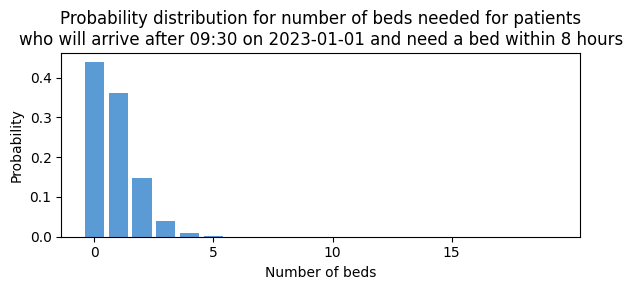

In [60]:
prob_dist_data = [poisson_model.pmf(k) for k in range(20)]

from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.utils import format_prediction_time
title = (
    f'Probability distribution for number of beds needed for patients'
    f'\nwho will arrive after {format_prediction_time((9,30))} on {snapshot_dates[0]} and need a bed within 8 hours'
)
prob_dist_plot(prob_dist_data, title,  
    include_titles=True)

## Train a weighted Poisson model

The model above has learned the rates of arrivals of patients who are later admitted within a prediction window. Note that the chart above, which is based on real patient data on the times patients were eventually admitted to a ward, the expected value for the number of patients arriving and being admitted within 8 hours is zero.  

A problem with this approach is that rates are learned from periods of poor performance. Currently, in England Emeregncy Departments have a target of processing all patients within four hours of their arrival time. If the Emergency Department is not meeting four-hour targets, patients will wait longer than the targets imply that they should.

The poor performance is illustrated by the survival curve below, which shows that only 59% of admitted patients left the ED to go to the ward within four hours. 

The approach therefore understates the 'true' or 'unfettered' level of demand if patients were not delayed.



Proportion of patients admitted within 4 hours: 58.76%


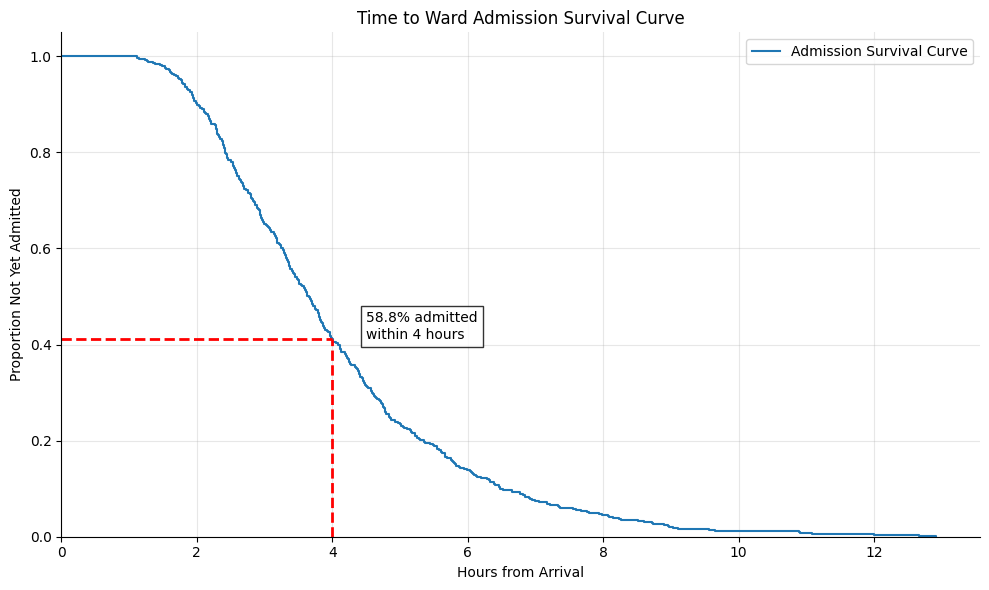

In [81]:
from patientflow.viz.survival_curves import plot_admission_time_survival_curve
plot_admission_time_survival_curve(inpatient_arrivals)

`patientflow` offers a weighted Poisson model, that will calculate each patient's probability of being admitted from their arrival time, if targets are met. Targets are set using the parameters set in config.yaml 

In [84]:
from patientflow.load import load_config_file, set_file_paths, set_project_root
project_root = set_project_root()

_, _, _, config_path = set_file_paths(project_root, data_folder_name = 'data-public', verbose = False)
params = load_config_file(config_path)

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]

print(f'The aspiration is that within {str(x1)} hours of arrival, {str(y1*100)}% of patients will have been admitted, and that witin {str(x2)} hours of arrival, {str(y2*100)}% of patients will have been admitted')

Inferred project root: /Users/zellaking/Repos/patientflow
The aspiration is that within 4.0 hours of arrival, 76.0% of patients will have been admitted, and that witin 12.0 hours of arrival, 99.0% of patients will have been admitted


The aspiration can be plotted as an inverted survival curve, as shown below. 

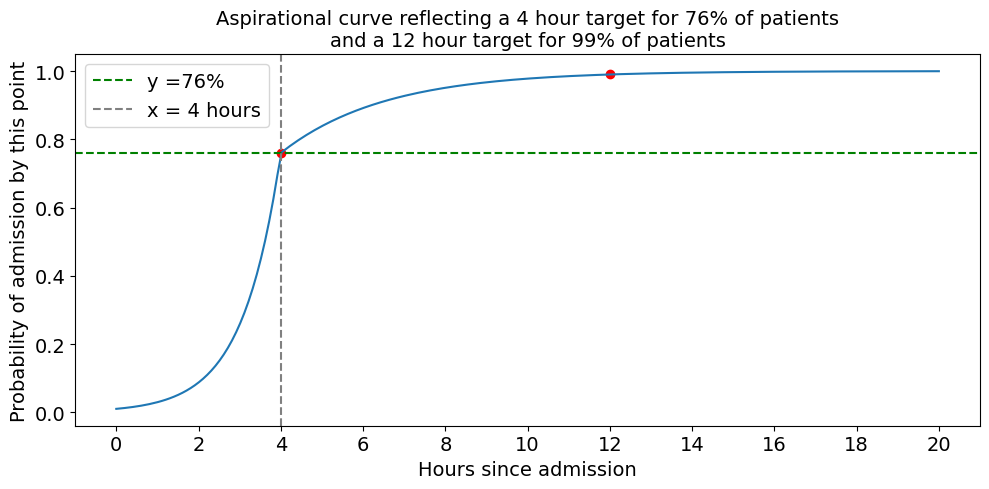

In [85]:
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)

plot_curve(
    title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients',
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    include_titles=True,
)
